In [1]:
#import libraries 
import ee
import folium
import geemap
import time
import ipywidgets as widgets
from ipyleaflet import Marker, Popup
import numpy as np
import cv2
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from IPython.display import display
import rasterio
from skimage.filters import threshold_otsu
from skimage.segmentation import random_walker
from skimage.measure import label, regionprops
from skimage import io
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
from skimage.feature import graycomatrix, graycoprops


In [2]:
# Retrive the Satellite Image 

# Initialize Earth Engine
ee.Initialize()

# Define the center coordinates of the location and specify the radius (10000 ft = ~3048 meters)
center = [11.57628,37.42476]  # Latitude, Longitude
radius = 3048  # Radius in meters

# Create a bounding box geometry
geometry = ee.Geometry.Point(center[1], center[0]).buffer(radius)

# Define the image collection for Sentinel-2, with cloud cover aa
collection = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(geometry) \
    .filterDate('2024-05-01', '2024-05-10')  \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))  # Filter for low cloud cover

# Check collection size before attempting to get the first image
collection_size = collection.size().getInfo()

if collection_size > 0:
    # Get the first image from the collection (if any)
    try:
        image = ee.Image(collection.first())
        # Print image ID for reference
        print("Image ID:", image.id().getInfo())

        # Create a map
        Map = geemap.Map(center=(center[0], center[1]), zoom=12)

        # Define visualization parameters
        vis_params = {
            'bands': ['B4', 'B3', 'B2'],  # Red, Green, Blue bands
            'min': 0,
            'max': 3000,
            'gamma': 1.4
        }

        # Add the image to the map with the defined visualization parameters
        Map.addLayer(image, vis_params, 'Sentinel-2 Image')
        Map.addLayer(geometry, {'color': 'pink'}, 'Location')

        # Add a layer control panel to the map
        Map.addLayerControl()

        # Display the map
        display(Map)

    except ee.EEException as e:
        print("Error retrieving image:", e)
else:
    print("No suitable images found in the Sentinel-2 collection for the specified location and date range.")


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\ee\deprecation.py:204: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


Image ID: 20240505T074611_20240505T080451_T37PCN


Map(center=[11.57628, 37.42476], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

In [2]:
# Load the image
image_path = r"sentinel2_images\sentinel2.jpg"
image = io.imread(image_path)

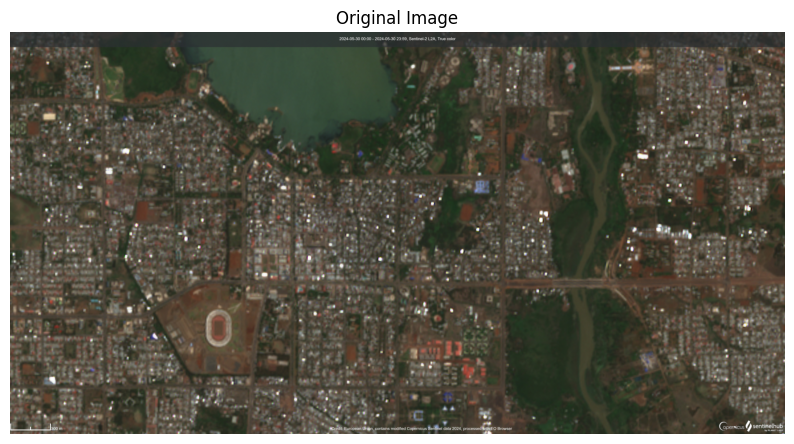

In [3]:
# Display the original image
plt.figure(figsize=(10, 10))
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')
plt.show()

In [4]:
# Load labeled images
image_paths = {
    'Farm': 'C:/Users/hp/Downloads/Picture/Farm.png',
    'Building': 'C:/Users/hp/Downloads/Picture/Building.png',
    'Water': 'C:/Users/hp/Downloads/Picture/Water.png',
    'Empty_Land': 'C:/Users/hp/Downloads/Picture/Empty Land.png',
    'Forest': 'C:/Users/hp/Downloads/Picture/Forest.png'
}

# Create labels for each image
labels = {
    'Farm': 0,
    'Building': 1,
    'Water': 2,
    'Empty_Land': 3,
    'Forest': 4
}

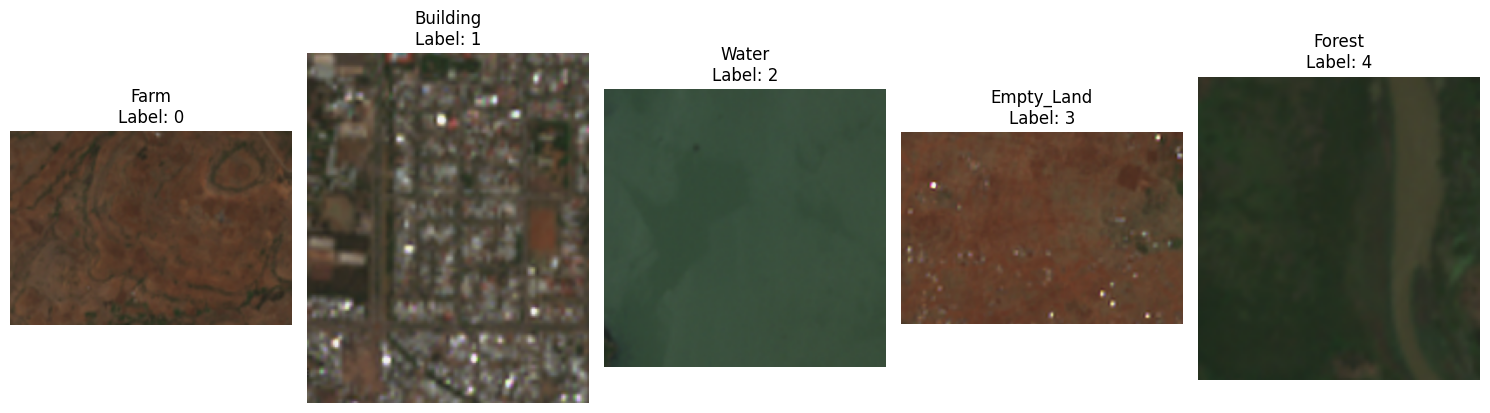

In [5]:
# Create a grid for plotting images
fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

for ax, (label, path) in zip(axes, image_paths.items()):
    img = mpimg.imread(path)
    ax.imshow(img)
    ax.set_title(f'{label}\nLabel: {labels[label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [6]:
def extract_texture_features(image, window_size=5):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    features = np.zeros((h, w, 5))  # 5 texture features

    for i in range(h - window_size):
        for j in range(w - window_size):
            window = gray[i:i + window_size, j:j + window_size]
            glcm = graycomatrix(window, [1], [0], 256, symmetric=True, normed=True)
            features[i, j, 0] = graycoprops(glcm, 'contrast')[0, 0]
            features[i, j, 1] = graycoprops(glcm, 'dissimilarity')[0, 0]
            features[i, j, 2] = graycoprops(glcm, 'homogeneity')[0, 0]
            features[i, j, 3] = graycoprops(glcm, 'energy')[0, 0]
            features[i, j, 4] = graycoprops(glcm, 'correlation')[0, 0]

    return features

In [7]:
def extract_features_and_labels(image, label):
    h, w, c = image.shape
    X_rgb = image.reshape(-1, c)
    texture_features = extract_texture_features(image)
    X_texture = texture_features.reshape(-1, 5)  # 5 texture features
    X = np.hstack((X_rgb, X_texture))
    y = np.full((h * w,), label)
    return X, y


In [8]:
X_list, y_list = [], []
for land_cover, path in image_paths.items():
    image = cv2.imread(path)
    X, y = extract_features_and_labels(image, labels[land_cover])
    X_list.append(X)
    y_list.append(y)

# Combine all features and labels
X = np.vstack(X_list)
y = np.concatenate(y_list)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [11]:
# Save the trained model
joblib.dump(clf, 'land_cover_classifier.pkl')

# Load the trained model (for later use)
clf = joblib.load('land_cover_classifier.pkl')


In [12]:
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=labels.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")


Classification Report:
              precision    recall  f1-score   support

        Farm       0.85      0.89      0.87     10495
    Building       0.95      0.93      0.94      6497
       Water       1.00      1.00      1.00      9043
  Empty_Land       0.84      0.81      0.83      8071
      Forest       0.97      0.99      0.98      3775

    accuracy                           0.91     37881
   macro avg       0.92      0.92      0.92     37881
weighted avg       0.91      0.91      0.91     37881

Confusion Matrix:
[[9306  102    0 1069   18]
 [ 232 6047    0  146   72]
 [   0    0 9016    0   27]
 [1348  197    0 6525    1]
 [   7   37    1    0 3730]]
Accuracy Score: 0.91


In [13]:
# Load the new satellite image to classify
image_path = r"sentinel2_images\sentinel2.jpg"
image = io.imread(image_path)

# Reshape the image to a 2D array of pixels
h, w, c = image.shape
X_rgb = image.reshape(-1, c)
texture_features = extract_texture_features(image)
X_texture = texture_features.reshape(-1, 5)  # 5 texture features
pixels = np.hstack((X_rgb, X_texture))

# Predict the class for each pixel
predicted_labels = clf.predict(pixels)

# Reshape the predicted labels back to the original image shape
predicted_labels = predicted_labels.reshape(image.shape[0], image.shape[1])

# Display the predicted land cover map
plt.figure(figsize=(10, 10))
plt.title('Predicted Land Cover Map')
plt.imshow(predicted_labels, cmap='tab10')
plt.axis('off')
plt.show()


In [ ]:
# Pre-processing: Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
# Apply Gaussian Blur for noise reduction
blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

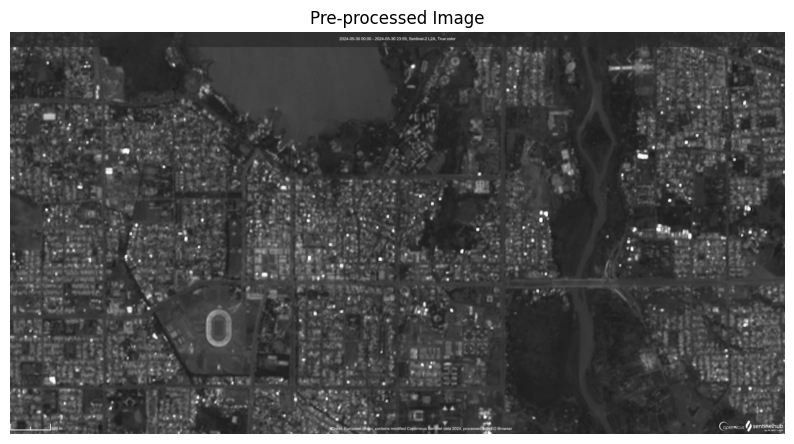

In [ ]:
# Display the pre-processed image
plt.figure(figsize=(10, 10))
plt.title('Pre-processed Image')
plt.imshow(blurred_image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Image Segmentation using KMeans
# Reshape the image to a 2D array of pixels
pixels = image.reshape(-1, 3)

# Perform KMeans clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(pixels)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]

In [ ]:
# Reshape the image back to the original shape
segmented_img = segmented_img.reshape(image.shape)
segmented_img = segmented_img.astype(np.uint8)

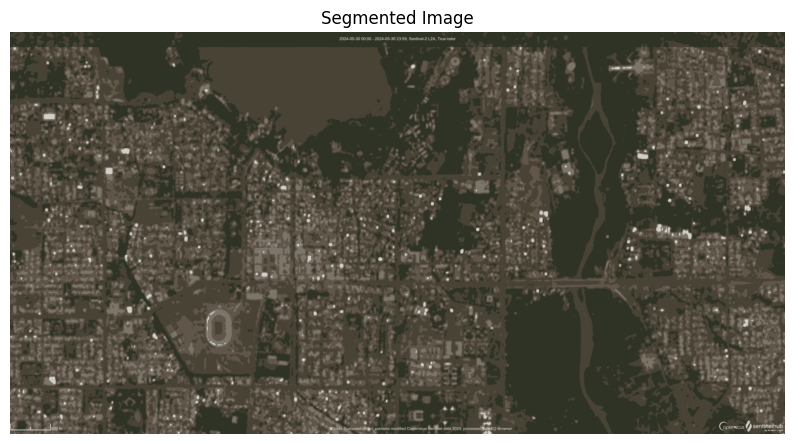

In [ ]:
# Display the segmented image
plt.figure(figsize=(10, 10))
plt.title('Segmented Image')
plt.imshow(segmented_img)
plt.axis('off')
plt.show()

In [ ]:
# Feature Extraction and Classification (simple example)
# Here, we will use the clustered segments as features
# In a real scenario, more advanced techniques and features would be used

# Map the clusters to land cover classes (example: 0 = Water, 1 = Urban, etc.)
cluster_labels = kmeans.labels_.reshape(image.shape[0], image.shape[1])
land_cover_map = np.zeros_like(cluster_labels)

In [ ]:
# Example mapping (this would be more complex in a real scenario)
# Assigning arbitrary classes for demonstration purposes
land_cover_classes = {
    0: "Water",
    1: "Urban",
    2: "Vegetation",
    3: "Bare Soil",
    4: "Other"
}

for cluster_id in range(num_clusters):
    land_cover_map[cluster_labels == cluster_id] = cluster_id

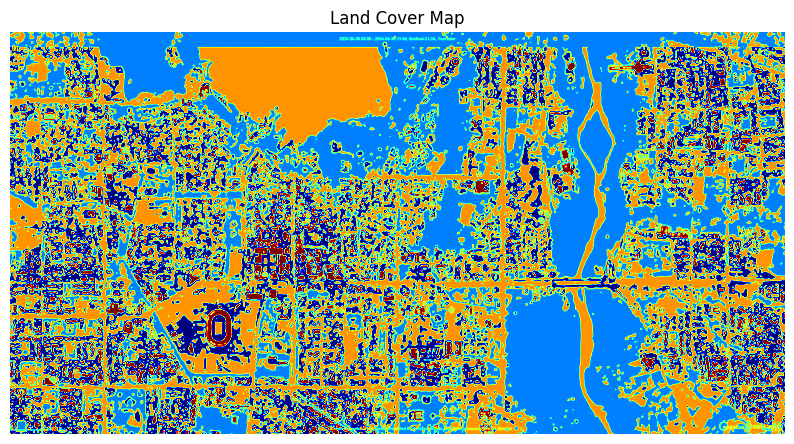

In [ ]:
# Display the land cover map
plt.figure(figsize=(10, 10))
plt.title('Land Cover Map')
plt.imshow(land_cover_map, cmap='jet')
plt.axis('off')
plt.show()